# Import packages and utils

In [21]:
import logging
import time
from contextlib import contextmanager
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
import multiprocessing_logging
from src.utils._get_data import DataHandler
import matplotlib.pyplot as plt
import seaborn as sns
# after setting up your logger
logging.basicConfig(level=logging.INFO)
multiprocessing_logging.install_mp_handler()


In [2]:
# Create a context manager for timing sections of code
@contextmanager
def log_time(section_name: str):
    """
    Context manager for timing sections of your code. 
    It logs completion time on successful completion of the with block.
    """
    start_time = time.time()
    yield
    end_time = time.time()
    elapsed_time = end_time - start_time
    logging.info(f"{section_name} completed in {elapsed_time} seconds")


# Dataset

## Load Datasets

Please see the DataHandler class from the following path for detailed implementation
* `src.utils._get_data.py -> DataHandler()`

In [11]:
# Describe the data you want to get
data_names = [
    'load_data',
    'load_forecast',
    'generation_data',
    'generation_forecast',
    'wind_and_solar_forecast',
    'day_ahead_prices'
]

# Describe the country code, start and end dates
country_code = 'DE_LU'
start = pd.Timestamp('2023-01-01', tz='Europe/Berlin')
end = pd.Timestamp('2023-06-01', tz='Europe/Berlin')


#### Add multiprocessing to speed up data loading process

In [12]:
# function to load a single dataset
def load_single_dataset(args):
    dataset_name, data_handler = args
    try:
        with log_time(dataset_name):
            df = data_handler._get_data(dataset_name)
            logging.info(f"{dataset_name} data retrieved successfully")
            return dataset_name, df
    except Exception as e:
        logging.error(f"Error while loading {dataset_name}: {e}")
        raise e

def load_dataset():
    df_dict = {} # Dictionary to store the dataframes
    try:
        with log_time("DataHandler"):
            data_handler = DataHandler()
            logging.info("DataHandler object created successfully")
            data_handler._set_data_settings(country_code, start, end)
            logging.info("DataHandler settings set successfully")
            with Pool(cpu_count()) as pool:
                results = pool.map(load_single_dataset, [(name, data_handler) for name in data_names])
            for dataset_name, df in results:
                df_dict[dataset_name] = df
    except Exception as e:
        logging.error(f"Error while creating DataHandler: {e}")
        raise e

    return df_dict


In [13]:
df_dict = load_dataset()

INFO:root:DataHandler object created successfully
INFO:root:DataHandler settings set successfully
INFO:root:generation_forecast data retrieved successfully
INFO:root:generation_forecast completed in 1.9134972095489502 seconds
INFO:root:load_data data retrieved successfully
INFO:root:load_data completed in 3.170311212539673 seconds
INFO:root:load_forecast data retrieved successfully
INFO:root:load_forecast completed in 4.186831474304199 seconds
INFO:root:day_ahead_prices data retrieved successfully
INFO:root:day_ahead_prices completed in 7.722548007965088 seconds
INFO:root:wind_and_solar_forecast data retrieved successfully
INFO:root:wind_and_solar_forecast completed in 12.476391315460205 seconds
INFO:root:generation_data data retrieved successfully
INFO:root:generation_data completed in 58.64530038833618 seconds
INFO:root:DataHandler completed in 58.75131177902222 seconds


## Getting Familiar with the Datasets

In [14]:
# Prin the type of each dataset in the dictionary
for dataset_name, df in df_dict.items():
    print(f"{dataset_name}: {type(df)}")
    

load_data: <class 'pandas.core.frame.DataFrame'>
load_forecast: <class 'pandas.core.frame.DataFrame'>
generation_data: <class 'pandas.core.frame.DataFrame'>
generation_forecast: <class 'pandas.core.frame.DataFrame'>
wind_and_solar_forecast: <class 'pandas.core.frame.DataFrame'>
day_ahead_prices: <class 'pandas.core.frame.DataFrame'>


In [15]:
# print the columns of the each dataset in the dictionary
for dataset_name, df in df_dict.items():
    print(f"{dataset_name}: {df.columns}")
    

load_data: Index(['Actual Load'], dtype='object')
load_forecast: Index(['Forecasted Load'], dtype='object')
generation_data: MultiIndex([(                        'Biomass',  'Actual Aggregated'),
            (      'Fossil Brown coal/Lignite',  'Actual Aggregated'),
            (                     'Fossil Gas',  'Actual Aggregated'),
            (               'Fossil Hard coal',  'Actual Aggregated'),
            (                     'Fossil Oil',  'Actual Aggregated'),
            (                     'Geothermal',  'Actual Aggregated'),
            (           'Hydro Pumped Storage',  'Actual Aggregated'),
            (           'Hydro Pumped Storage', 'Actual Consumption'),
            ('Hydro Run-of-river and poundage',  'Actual Aggregated'),
            (          'Hydro Water Reservoir',  'Actual Aggregated'),
            (                        'Nuclear',  'Actual Aggregated'),
            (                          'Other',  'Actual Aggregated'),
            (          

In [16]:
# print the frequency and length of the each dataset in the dictionary
for dataset_name, df in df_dict.items():
    print(f"{dataset_name}: {df.index.freq} {len(df)}")
    

load_data: <15 * Minutes> 14492
load_forecast: <15 * Minutes> 14492
generation_data: <15 * Minutes> 14492
generation_forecast: <60 * Minutes> 3623
wind_and_solar_forecast: <15 * Minutes> 14492
day_ahead_prices: <60 * Minutes> 3624


In [17]:
# print the data types of each dataset in the dictionary
for dataset_name, df in df_dict.items():
    print(f"{dataset_name}: {df.dtypes}")

load_data: Actual Load    float64
dtype: object
load_forecast: Forecasted Load    float64
dtype: object
generation_data: Biomass                          Actual Aggregated     float64
Fossil Brown coal/Lignite        Actual Aggregated     float64
Fossil Gas                       Actual Aggregated     float64
Fossil Hard coal                 Actual Aggregated     float64
Fossil Oil                       Actual Aggregated     float64
Geothermal                       Actual Aggregated     float64
Hydro Pumped Storage             Actual Aggregated     float64
                                 Actual Consumption    float64
Hydro Run-of-river and poundage  Actual Aggregated     float64
Hydro Water Reservoir            Actual Aggregated     float64
Nuclear                          Actual Aggregated     float64
Other                            Actual Aggregated     float64
Other renewable                  Actual Aggregated     float64
Solar                            Actual Aggregated     float

In [18]:
# print describve statistics of each dataset in the dictionary
for dataset_name, df in df_dict.items():
    print(f"{dataset_name}: {df.describe()}")

load_data:         Actual Load
count  14492.000000
mean   55028.614408
std     8686.586100
min    35231.000000
25%    47802.000000
50%    54818.500000
75%    62692.500000
max    72402.000000
load_forecast:        Forecasted Load
count     14492.000000
mean      55790.010489
std        9168.626435
min       32959.000000
25%       48420.750000
50%       55892.000000
75%       63600.250000
max       74287.000000
generation_data:                 Biomass Fossil Brown coal/Lignite        Fossil Gas  \
      Actual Aggregated         Actual Aggregated Actual Aggregated   
count      13336.000000              14492.000000      14488.000000   
mean        4679.318611               9731.934930       6135.536099   
std          200.653334               3599.767492       2903.868412   
min         4216.000000               3140.000000       1920.000000   
25%         4527.000000               6718.250000       3980.500000   
50%         4659.500000               9565.500000       5398.000000   
75

In [19]:
# find the number of NaNs in each dataset in the dictionary
for dataset_name, df in df_dict.items():
    print(f"{dataset_name}: {df.isna().sum()}")
    

load_data: Actual Load    0
dtype: int64
load_forecast: Forecasted Load    0
dtype: int64
generation_data: Biomass                          Actual Aggregated     1156
Fossil Brown coal/Lignite        Actual Aggregated        0
Fossil Gas                       Actual Aggregated        4
Fossil Hard coal                 Actual Aggregated        0
Fossil Oil                       Actual Aggregated        0
Geothermal                       Actual Aggregated        0
Hydro Pumped Storage             Actual Aggregated        0
                                 Actual Consumption       0
Hydro Run-of-river and poundage  Actual Aggregated        4
Hydro Water Reservoir            Actual Aggregated        4
Nuclear                          Actual Aggregated     2530
Other                            Actual Aggregated        0
Other renewable                  Actual Aggregated        0
Solar                            Actual Aggregated        4
                                 Actual Consumption  

Most of the nuclear columns are missing in generation data. Let's visualize each dataset individually and see what we can do for those missing values before the feature engineering. Also the good news that there are no NaN in price dataset which we want to predict it. So only generation dataset is problematic 

## Visualize the Datasets

### 1. Visualizing Individual Datasets

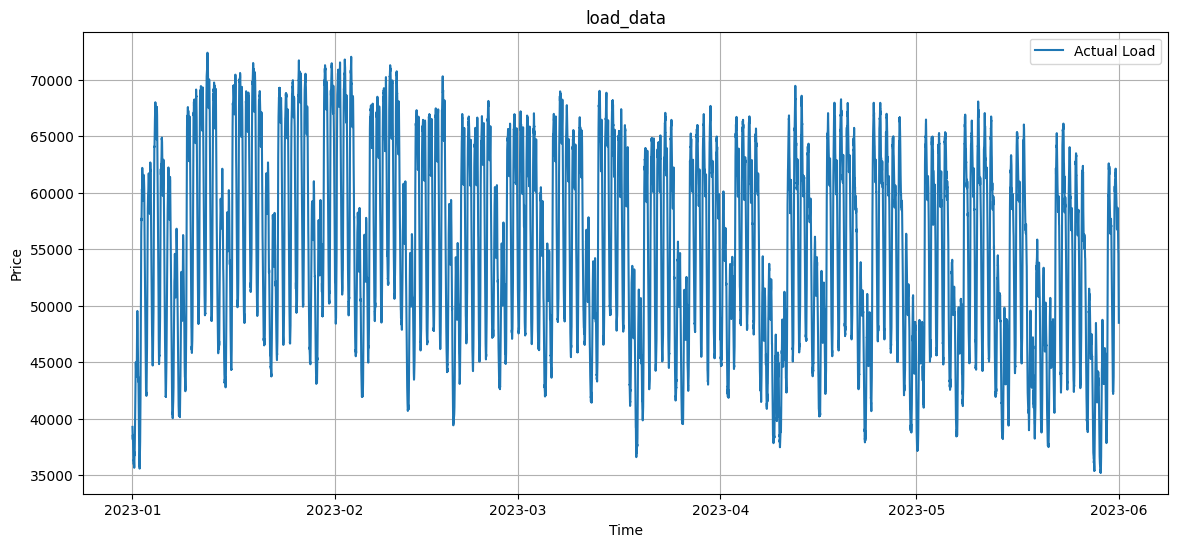

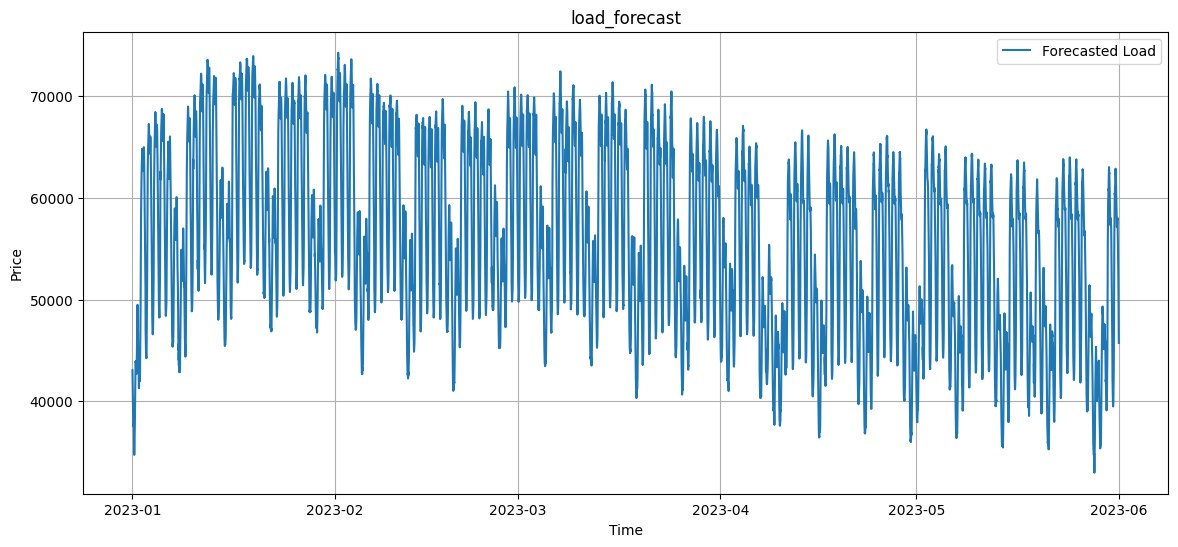

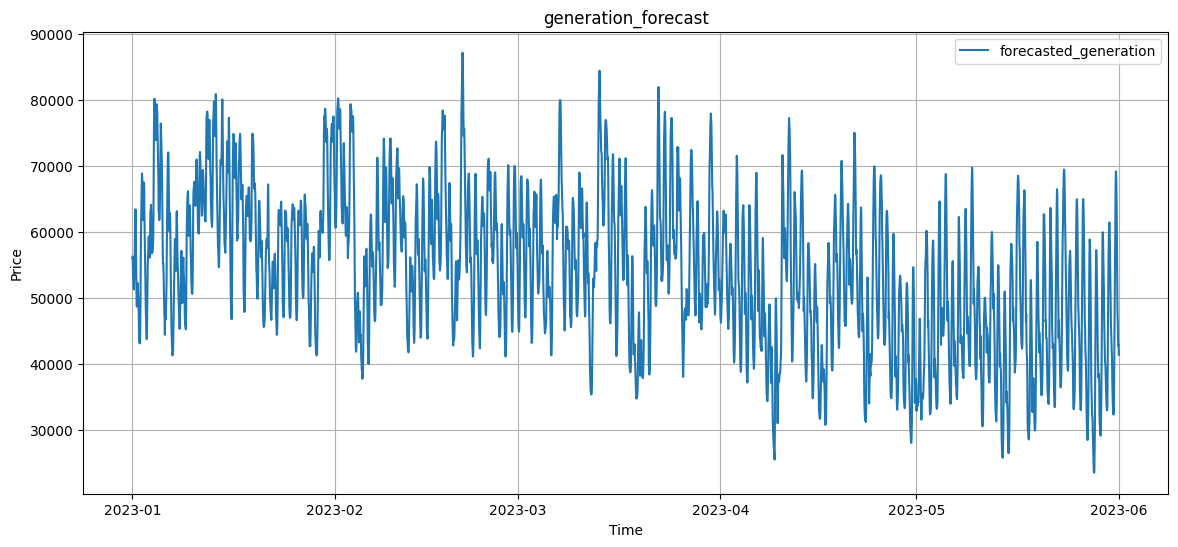

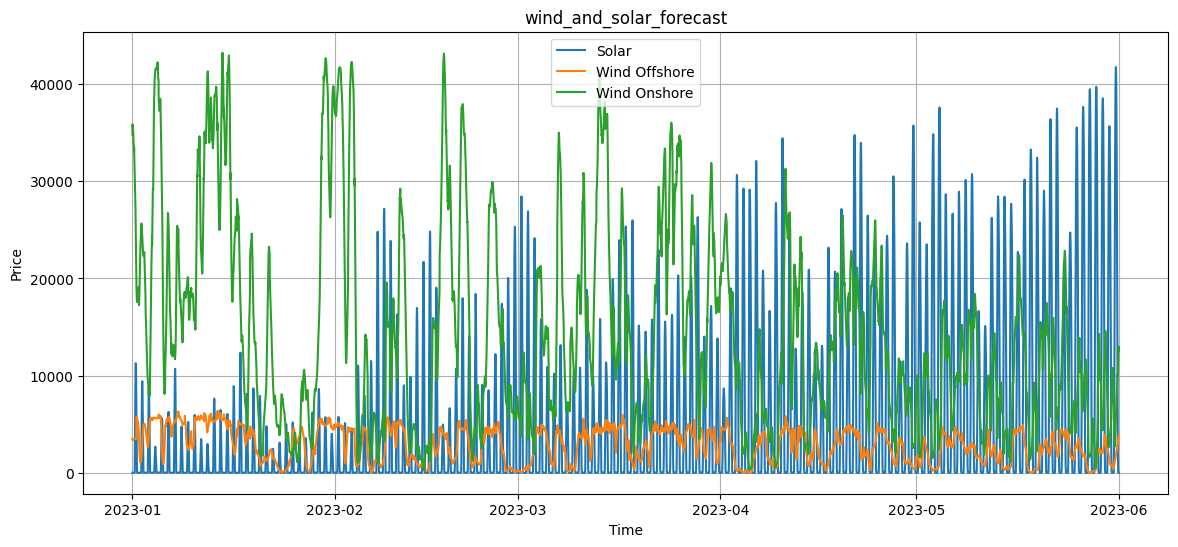

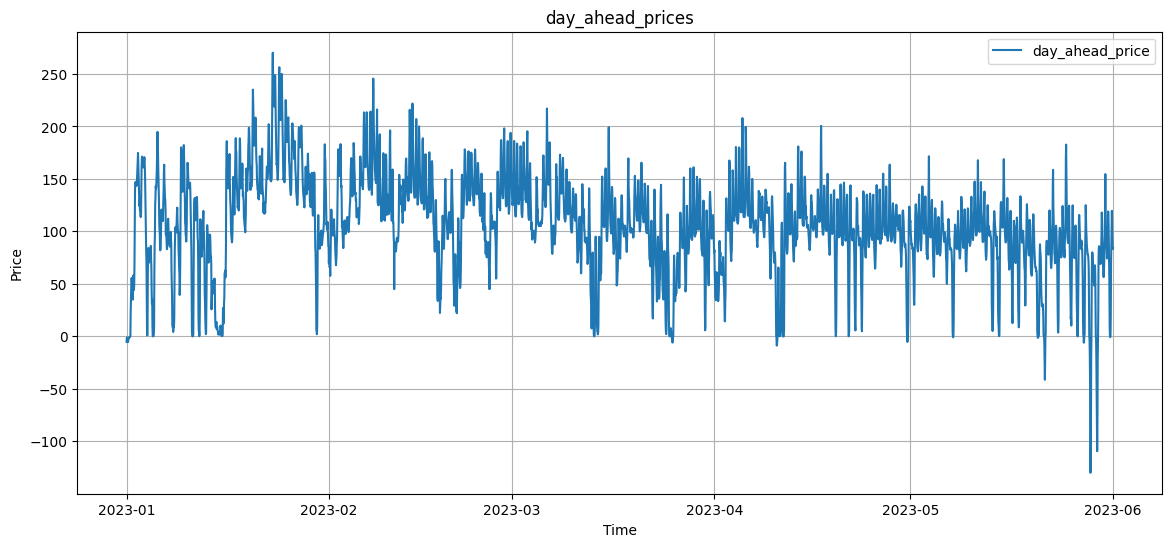

In [29]:
# plot each dataset in the dictionary except generation_data because it is multi-dimensional(indexed)
for dataset_name, df in df_dict.items():
    if dataset_name != 'generation_data' :
        plt.figure(figsize=(14,6))
        plt.plot(df)
        plt.title(dataset_name)
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.grid(True)
        # add legend
        plt.legend(df.columns)
        plt.show()

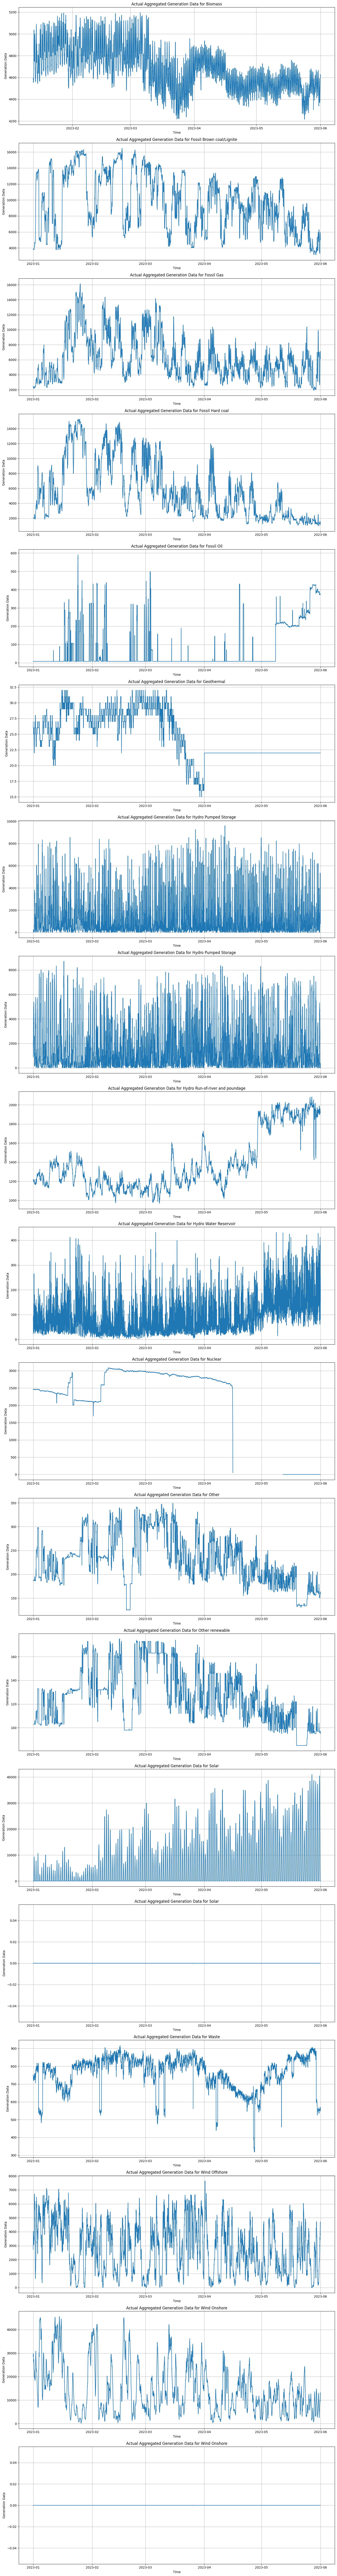

In [27]:
# Plot generation_data
fig, ax = plt.subplots(len(df_dict['generation_data'].columns), 1, figsize=(15, 6*len(df_dict['generation_data'].columns)))

for i, col in enumerate(df_dict['generation_data'].columns):
    ax[i].plot(df_dict['generation_data'][col])
    ax[i].set_title(f'Actual Aggregated Generation Data for {col[0]}')
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Generation Data')
    ax[i].grid(True)

plt.tight_layout()
plt.show()


### 2. Visualizing Relationships

#### 2.1 Acutal Load vs Actual Generation

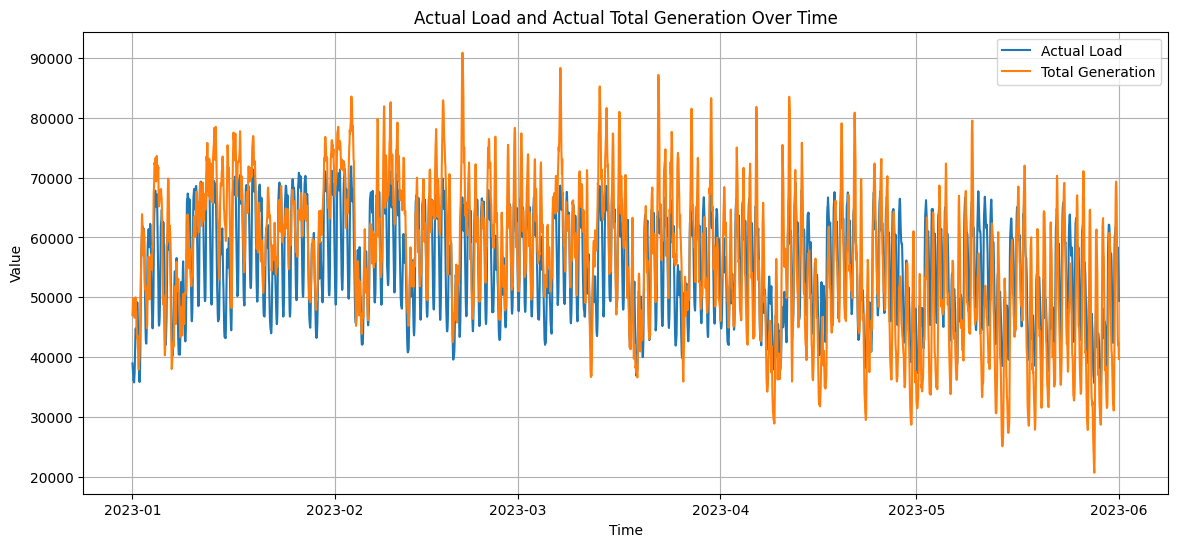

In [41]:
# Let's create a combined DataFrame
combined_df = pd.concat([df_dict['load_data'].resample('1H').mean(), 
                         df_dict['generation_data'].resample('1H').mean().sum(axis=1)], axis=1)
combined_df.columns = ['Actual Load', 'Total Generation']


plt.figure(figsize=(14,6))

plt.plot(combined_df['Actual Load'], label='Actual Load')
plt.plot(combined_df['Total Generation'], label='Total Generation')

plt.title('Actual Load and Actual Total Generation Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


